<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/rnn_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

In [2]:
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'

path_file = 'df_movies_rating_2.csv'

sys.path.append(path_absolute)


El código se está ejecutando en un entorno local.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Utils.utils as util


from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate


# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset


In [4]:
dataFrame = pd.read_csv(path_absolute+path_file, sep=',')
data = dataFrame.copy()

In [5]:
if IN_COLAB:
    tamano_muestra = data.shape[0] #834.730
else:
    # Especifica el tamaño de la muestra que deseas obtener
    tamano_muestra = 60000

In [6]:
# Obtiene una muestra aleatoria uniforme del DataFrame
data = data.sample(n=tamano_muestra, random_state=42)  # random_state para reproducibilidad
tamano_muestra = data.shape[0]  # Cambia esto al tamaño de muestra que desees
tamano_muestra

60000

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 550126 to 799709
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              60000 non-null  int64  
 1   movieId             60000 non-null  int64  
 2   timestamp_scr       60000 non-null  int64  
 3   tag                 60000 non-null  object 
 4   tag_encoded         60000 non-null  int64  
 5   timestamp_tags      60000 non-null  int64  
 6   title               60000 non-null  object 
 7   (no genres listed)  60000 non-null  int64  
 8   Action              60000 non-null  int64  
 9   Adventure           60000 non-null  int64  
 10  Animation           60000 non-null  int64  
 11  Children            60000 non-null  int64  
 12  Comedy              60000 non-null  int64  
 13  Crime               60000 non-null  int64  
 14  Documentary         60000 non-null  int64  
 15  Drama               60000 non-null  int64  
 16

Quito las calumnas categoricas de título y tag ambas estan represnetadas en las columnas númericas de tag_encode e id movie.

In [8]:
# util.contar_ocurrencias(data, '(no genres listed)')
# util.mostrar_filas_por_valor(data, '(no genres listed)', 1)

Total de clases(Puntuaciones) a predecir

In [9]:
4.0,5.0,3.5,4.5,3.0,2.5,1.0,1.5,0.5
data = util.eliminar_columnas(data, ['tag', 'title', '(no genres listed)'])
util.contar_ocurrencias(data, 'rating')

Valor: 4.0, Frecuencia: 13536
Valor: 5.0, Frecuencia: 12260
Valor: 4.5, Frecuencia: 9864
Valor: 3.5, Frecuencia: 9289
Valor: 3.0, Frecuencia: 6384
Valor: 2.5, Frecuencia: 3161
Valor: 2.0, Frecuencia: 2318
Valor: 1.5, Frecuencia: 1212
Valor: 1.0, Frecuencia: 1057
Valor: 0.5, Frecuencia: 919
Total de valores distintos: 10


In [10]:
data = util.eliminar_columnas(data, ['timestamp_tags', 'timestamp_scr'])

In [11]:
data.head()

,userId,movieId,tag_encoded,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
550126,64333,42197,31405,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.5
722840,15078,3993,2699,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.0
606031,141263,5459,9448,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0
49993,133400,134130,4293,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.0
122599,18057,4226,1582,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,5.0


# MODELO CON KERAS

In [12]:
# # Dividir datos en entrenamiento y prueba
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# train_data_scaled = train_data.drop("rating", axis=1)
# test_data_scaled = test_data.drop("rating", axis=1)
# num_features = len(train_data.columns) - 1

# # Normalizar datos
# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_data_scaled)
# test_data_scaled = scaler.transform(test_data_scaled)

# # Construir el modelo de recomendación sin escalado
# model = Sequential()

# # Capas de entrada para datos numéricos
# model.add(Dense(128, activation='relu', input_shape=(num_features,)))
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))  # Nueva capa
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))  # Otra nueva capa
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal')) 
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal')) 

# # Capa de salida para predicción de puntuación
# model.add(Dense(1, activation='linear'))

# # Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'accuracy'])

# # Entrenar el modelo
# history = model.fit(train_data_scaled, train_data['rating'], epochs=100, batch_size=256, validation_split=0.2, verbose=0)

# # Evaluar el modelo en el conjunto de prueba
# loss, mae, accuracy = model.evaluate(test_data_scaled, test_data['rating'])
# print(f'Mean Absolute Error on Test Data: {mae}')


# # Realizar predicciones
# predictions = model.predict(test_data_scaled)

# util.plot_loss(history)
# util.plot_accuracy(history)

    GRÁFICA DE DISPERSIÓN

In [13]:

# # Realizar predicciones en el conjunto de prueba
# predictions = model.predict(test_data_scaled)

# # Obtener las puntuaciones reales y predicciones en una escala común (por ejemplo, de 0 a 5)
# y_true = test_data['rating'].values
# y_pred = predictions.flatten()  # Utilizamos flatten para convertir la matriz en un array unidimensional

# y_pred_round2 = np.clip(predictions.flatten(), 0.5, 5)  # Limitar los valores entre 0.5 y 5
# y_pred_round2 = np.round(y_pred_round2 * 2) / 2  # Redondear a 0.5
# y_pred = y_pred_round2

# y_pred = [round(val[0], 1) for val in predictions]
# # util.contar_ocurrencias_array(predictions_formatted)

# # Scatter plot de los valores reales frente a los valores predichos
# plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
# plt.plot([0.5, 5], [0.5, 5], linestyle='-', color='red', linewidth=2)  # Línea de 45 grados para referencia

# # Personalización del gráfico
# plt.title('Predicciones vs. Valores Reales')
# plt.xlabel('Valores Reales')
# plt.ylabel('Valores Predichos')
# plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
# plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
# plt.grid(True)

# # Mostrar el gráfico
# plt.show()

# # Crear un diagrama de dispersión con colores
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_true, y=y_pred, color='red', label='Predicciones')
# sns.scatterplot(x=y_true, y=y_true, color='green', label='Puntuaciones Reales')  # La línea diagonal de las puntuaciones reales
# plt.title('Diagrama de Dispersión: Puntuaciones Reales vs. Predicciones')
# plt.xlabel('Puntuaciones Reales')
# plt.ylabel('Predicciones del Modelo')
# plt.legend()
# plt.show()

# # Calcular el error cuadrático medio (MSE)
# mse = mean_squared_error(y_true, y_pred)
# print(f'Mean Squared Error (MSE): {mse}')

# MODELO CON KERAS CON PROCENTAJES

Cambios clave en este código:

- Número de Clases: La capa de salida ahora tiene un número de nodos igual al número de clases únicas en las valoraciones. Esto se determina mediante num_classes.

- Activación Softmax: La capa de salida utiliza la función de activación softmax, que asigna una probabilidad a cada clase y garantiza que la suma de las probabilidades sea igual a 1.

- Loss Function: El modelo utiliza la pérdida categorical_crossentropy porque estamos tratando con múltiples clases.

- One-Hot Encoding: Convertimos las etiquetas de las valoraciones a formato one-hot encoding para adaptarse al formato de salida de la red neuronal.

Después de entrenar el modelo, las predicciones (predictions_proba) serán matrices de probabilidad para cada clase. Puedes interpretar la probabilidad más alta como la predicción de la valoración que el modelo considera más probable para cada ejemplo.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2944      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 17,770
Trainable params: 17,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
300/300 [==============================]

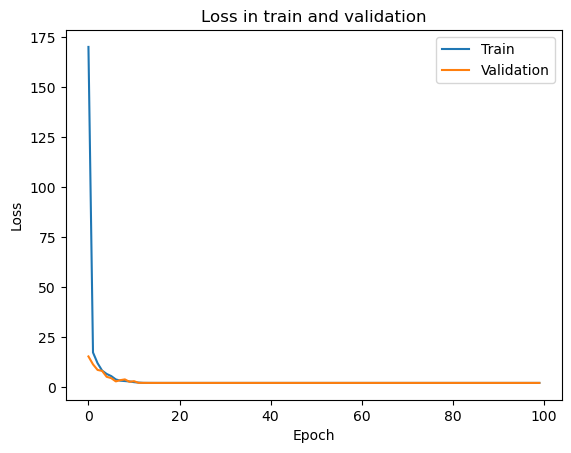

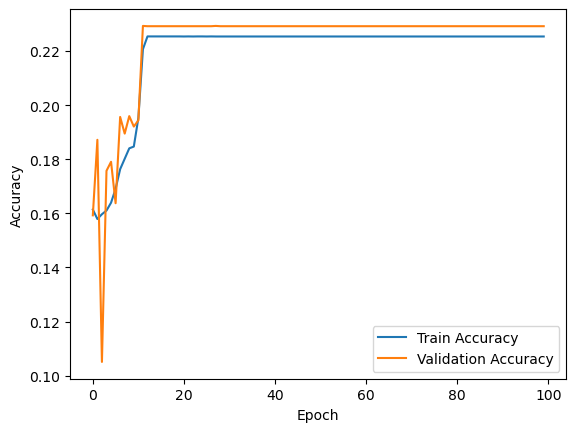

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data_scaled = train_data.drop("rating", axis=1)
test_data_scaled = test_data.drop("rating", axis=1)
num_features = len(train_data.columns) - 1

# Normalizar datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

X_train = train_data_scaled
X_test = test_data_scaled
# y_train =  train_data["rating"]
# y_test = test_data["rating"]
y_train = pd.get_dummies(train_data['rating'])
y_test = pd.get_dummies(test_data['rating'])

# num_classes = y_test.nunique()
num_classes = len(data['rating'].unique())

# Construir el modelo de recomendación con predicción de probabilidad
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_features,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


# Ajustar el learning rate al optimizador Adam
learning_rate = 0.001  # Puedes ajustar este valor según sea necesario
optimizer = Adam(learning_rate=learning_rate)


# model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Entrenar el modelo
# history_perc = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test),  verbose=1)
history_perc = model.fit(train_data.drop('rating', axis=1), y_train, epochs=100, batch_size=128, validation_split=0.2)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on Test Data: {accuracy}')

# Realizar predicciones de probabilidad
predictions_proba = model.predict(X_test)

util.plot_loss(history_perc)
util.plot_accuracy(history_perc)


In [15]:
# Convertir las etiquetas a formato one-hot encoding
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)

# Asegurarse de que las columnas en y_train_onehot y y_test_onehot coincidan
# Esto es necesario porque puede haber algunas clases ausentes en el conjunto de prueba
y_test_onehot = y_test_onehot.reindex(columns=y_train_onehot.columns, fill_value=0)

# Imprimir el orden de las clases
print(y_train_onehot.columns)

Float64Index([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64')


In [16]:
rating = [0.5,1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
predicciones_correctas = 0
for indx in range(len(y_test)):
    max_index = np.argmax(predictions_proba[indx]) + 1
    max_value = predictions_proba[indx][max_index]
    if rating[max_index] == y_test.values[indx]:
        predicciones_correctas = predicciones_correctas + 1
    # print(f"Vector: {predictions_proba[0]}")
    # print(f"El mayor elemento del vector es: {max_value}")
    # print(f"El índice del mayor elemento es: {max_index} --> RATING: {rating[max_index]}")
    # print(f"El VALOR ESPERADO ES: {y_test.values[indx]}")
print(f"Total de predicciones: {indx}")
print(f"Total de correctas: {predicciones_correctas}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
rating = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Obtener el índice del máximo en cada fila
indices_maximos = np.argmax(predictions_proba, axis=1)

# Obtener las calificaciones predichas
calificaciones_predichas = rating[indices_maximos+1]

    GRÁFICA DE DISPERSIÓN

In [ ]:
# Scatter plot de los valores reales frente a los valores predichos
plt.scatter(y_test.values, calificaciones_predichas, color='blue', alpha=0.5)
plt.plot([0.5, 5], [0.5, 5], linestyle='-', color='red', linewidth=2)  # Línea de 45 grados para referencia

# Personalización del gráfico
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Mostrar el gráfico
plt.show()

In [ ]:
residual = y_test - calificaciones_predichas
sns.distplot(residual)
plt.title("Distribución de los residuos")
plt.xlabel("residuals")
plt.ylabel("frequency")

    KERAS SIMPLIFICADO

In [ ]:
# # Dividir datos en entrenamiento y prueba
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# # Normalizar datos
# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])
# test_data_scaled = scaler.transform(test_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])

# # Construir el modelo de recomendación
# model = Sequential()

# # Capas de entrada para datos numéricos
# model.add(Dense(64, activation='relu', input_shape=(train_data_scaled.shape[1],)))
# model.add(Dense(32, activation='relu'))

# # Capa de salida para predicción de puntuación
# model.add(Dense(1, activation='linear'))

# #--------------------------------------------------------------------------------------------------------------------------------------------------#

# # Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# # Entrenar el modelo
# model.fit(train_data_scaled, train_data['rating'], epochs=10, batch_size=64, validation_split=0.2)

# # Evaluar el modelo en el conjunto de prueba
# loss, mae = model.evaluate(test_data_scaled, test_data['rating'])
# print(f'Mean Absolute Error on Test Data: {mae}')

# # Realizar predicciones
# predictions = model.predict(test_data_scaled)


# MODELO CON TORCH

In [ ]:
# # Preprocesamiento de datos
# num_movies = data['movieId'].nunique()

# # Define el tamaño máximo del índice + 1 (porque los índices comienzan desde 0)
# input_dim = max(max(data['userId']), max(data['movieId'])) + 1
# num_movies = input_dim

# # Crear embeddings para usuarios y películas
# user_embedding = nn.Embedding(input_dim, 50)
# movie_embedding = nn.Embedding(input_dim, 50)

# # Crear conjuntos de entrenamiento y prueba
# train, test = train_test_split(data, test_size=0.2, random_state=42)

# # Preparar datos para DataLoader
# train_users = torch.LongTensor(train['userId'].values)
# train_movies = torch.LongTensor(train['movieId'].values)
# train_ratings = torch.FloatTensor(train['rating'].values)

# test_users = torch.LongTensor(test['userId'].values)
# test_movies = torch.LongTensor(test['movieId'].values)
# test_ratings = torch.FloatTensor(test['rating'].values)

# train_dataset = TensorDataset(train_users, train_movies, train_ratings)
# test_dataset = TensorDataset(test_users, test_movies, test_ratings)

# # Crear DataLoader
# batch_size = 512
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

# # Definir el modelo de recomendación
# class Recommender(nn.Module):
#     def __init__(self, num_usr, num_movs, embedding_size=50, hidden_size=128):
#         super(Recommender, self).__init__()
#         self.user_embedding = nn.Embedding(num_usr, embedding_size)
#         self.movie_embedding = nn.Embedding(num_movs, embedding_size)
#         self.fc1 = nn.Linear(embedding_size * 2, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 1)

#     def forward(self, user, movie):
#         user_embed = self.user_embedding(user)
#         movie_embed = self.movie_embedding(movie)
#         x = torch.cat([user_embed, movie_embed], dim=1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Instanciar el modelo, la función de pérdida y el optimizador
# model = Recommender(input_dim, num_movies)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Entrenar el modelo
# num_epochs = 100

# print_interval = int(num_epochs / 10)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for user, movie, rating in train_loader:
#         optimizer.zero_grad()
#         output = model(user, movie).view(-1)
#         loss = criterion(output, rating)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * user.size(0)
#     train_loss /= len(train_loader.dataset)
#     # Imprimir progreso cada 10% de las épocas
#     if (epoch + 1) % print_interval == 0 or epoch == num_epochs - 1:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')
#     # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# # Evaluar el modelo en el conjunto de prueba
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for user, movie, rating in test_loader:
#         output = model(user, movie).view(-1)
#         print(f'REAL RATINFG: {rating} ------------ PREDICT RATING {output}')
#         loss = criterion(output, rating)
#         test_loss += loss.item() * user.size(0)
# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss:.4f}')


In [ ]:
# # Cargar datos (por ejemplo, desde un archivo CSV)
# # Suponiendo que tienes un DataFrame llamado 'data' con columnas 'userId', 'movieId' y 'rating'
# # ...

# # Preprocesamiento de datos
# # Define el tamaño máximo del índice + 1 (porque los índices comienzan desde 0)
# input_dim = max(max(data['userId']), max(data['movieId'])) + 1

# # Define el tamaño de la capa de embeddings (puedes ajustar este valor según sea necesario)
# embedding_size = 50

# # Crear conjuntos de entrenamiento y prueba
# train, test = train_test_split(data, test_size=0.2, random_state=42)

# # Definir la arquitectura del modelo de recomendación
# user_input = Input(shape=(1,))
# movie_input = Input(shape=(1,))

# user_embedding = Embedding(input_dim=input_dim, output_dim=embedding_size)(user_input)
# movie_embedding = Embedding(input_dim=input_dim, output_dim=embedding_size)(movie_input)

# user_flat = Flatten()(user_embedding)
# movie_flat = Flatten()(movie_embedding)

# concatenated = Concatenate()([user_flat, movie_flat])

# dense_1 = Dense(128, activation='relu')(concatenated)
# output = Dense(1)(dense_1)

# # Crear el modelo
# model = Model(inputs=[user_input, movie_input], outputs=output)

# # Compilar el modelo
# model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

# # Entrenar el modelo
# model.fit([train['userId'], train['movieId']], train['rating'], batch_size=512, epochs=100, validation_split=0.2, verbose=0)

# # Evaluar el modelo en el conjunto de prueba
# loss = model.evaluate([test['userId'], test['movieId']], test['rating'])
# print(f'Loss en el conjunto de prueba: {loss}')


    MATRIZ DE CONFUSIÓN

In [ ]:
# from sklearn.metrics import confusion_matrix
# import itertools

# labels = [1,2,3,4,5,6,7,8,10]
# label = ['True label','Predicted label']
# title='Confusion matrix, without normalization'
# title='Confusion matrix, without normalization'
# classes = ['0.5','1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

# # Discretizar las etiquetas continuas en intervalos
# bins = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# test_data['rating_discrete'] = pd.cut(test_data['rating'], bins=bins, labels=False)
# y_pred_discrete = pd.cut(y_pred, bins=bins, labels=False)

# print(f'RATING_DISCRETE ----------------------> {test_data["rating_discrete"]}')
# print(f'PREDICT_DISCRTE ----------------------> {y_pred_discrete}')

# # Crear la matriz de confusión
# mx_confusion = confusion_matrix(test_data['rating_discrete'], y_pred_discrete, labels=labels)

# # Restablecer las etiquetas si es necesario
# test_data.drop('rating_discrete', axis=1, inplace=True)



# # mx_confusion=confusion_matrix(test_data['rating'], y_pred, labels = labels)


# plt.figure(figsize=(12,8))


# cm = mx_confusion

# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title(title)
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)
# fmt = '.2f'
# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")
# plt.ylabel(label[0])
# plt.xlabel(label[1])
# plt.tight_layout()


# plt.show()

141/141 [==============================] - 0s 2ms/step
array([[4.589011 ],
       [4.25576  ],
       [3.8613555],
       ...,
       [2.9798229],
       [3.4627032],
       [3.630815 ]], dtype=float32)


































(20000263, 4)
userId	movieId	rating	timestamp
0	1	2	3.5	12/09/2023, 10:13:58
1	1	29	3.5	12/09/2023, 10:13:58
2	1	32	3.5	12/09/2023, 10:13:58
3	1	47	3.5	12/09/2023, 10:13:58
4	1	50	3.5	12/09/2023, 10:13:58
Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002
userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64
userId	movieId	rating	timestamp
0	1	2	3.5	12/09/2023, 10:13:58
1	1	29	3.5	12/09/2023, 10:13:58
2	1	32	3.5	12/09/2023, 10:13:58
3	1	47	3.5	12/09/2023, 10:13:58
4	1	50	3.5	12/09/2023, 10:13:58
userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64
userId	movieId	rating	timestamp
4943	49	50	5.0	12/09/2023, 10:13:58
4944	49	163	3.5	12/09/2023, 10:13:58
4945	49	216	3.0	12/09/2023, 10:13:58
4946	49	296	5.0	12/09/2023, 10:13:58
4947	49	333	3.0	12/09/2023, 10:13:58
originalMovieId	newMovieId
0	50	1
1	163	2
2	216	3
3	296	4
4	333	5
originalUserId	newUserId
0	49	1
1	260	2
2	311	3
3	319	4
4	499	5
userId	movieId	rating	timestamp	newMovieId	newUserId
0	49	50	5.0	12/09/2023, 10:13:58	1	1
1	49	163	3.5	12/09/2023, 10:13:58	2	1
2	49	216	3.0	12/09/2023, 10:13:58	3	1
3	49	296	5.0	12/09/2023, 10:13:58	4	1
4	49	333	3.0	12/09/2023, 10:13:58	5	1
Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213
Shape of train set: (81191, 6)
Shape of validation set: (4511, 6)
Shape of test set:  (4511, 6)
Size of train set: 487146
Size of validation set: 27066
Size of test set:  27066
Sparsity: 8.12%
array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])
Mean  Squared Error is :  1.055420084238528
Mean squared error using user average: 0.9090717929472647
Mean squared error using movie average: 0.9136057106858655
Number of Latent Factors: 1
User Input Shape: (None, 1)
User Embedding Shape: (None, 1, 1)
Flattened User Vector Shape: (None, 1)
Movie Input Shape: (None, 1)
Movie Embedding Shape: (None, 1, 1)
Flattened Movie Vector Shape: (None, 1)
Product Shape: (None, 1)
Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 1)         1001        ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 1)         1001        ['user[0][0]']                   
                                                                                                  
 flatten_movies (Flatten)       (None, 1)            0           ['movie_embedding[0][0]']        
                                                                                                  
 flatten_users (Flatten)        (None, 1)            0           ['user_embedding[0][0]']         
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['flatten_movies[0][0]',         
                                                                  'flatten_users[0][0]']          
                                                                                                  
==================================================================================================
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
__________________________________________________________________________________________________
Model Compiled Successfully